In [1]:
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np
import pandas as pd
import ipywidgets as widgets

import csv, os

import scipy.stats as statistics

## Load Data

In [50]:
# USER CHANGEABLE PARAMETERS
ManySizeBy1_toggle = False

# Loads labelled data
filename_info = 'THE_WHEEL_12_31_2019_CHESTFINALSUBJECTS.xls'

pt_info = pd.read_excel(filename_info)
pt_info['label'] = pt_info['Group_Arb2'].map({0: 'control',
                                              1: 'pah',
                                              5: 'epah'})
pt_info['SID'] = pt_info['SID'].astype(str).str.zfill(3)

label_dict = dict(zip(pt_info['SID'].to_list(), pt_info['label'].to_list()))

# Expects all relevant files to be in these folders
folders = [
    os.path.join('FDs_data', 'FDs_DNN_SCALE'),
    os.path.join('FDs_data', 'FDs_FACTOR_SCALE', 'FDs_FACTOR_0_5_SCALE'),
    os.path.join('FDs_data', 'FDs_FACTOR_SCALE', 'FDs_FACTOR_1_0_SCALE'),
    os.path.join('FDs_data', 'FDs_FACTOR_SCALE', 'FDs_FACTOR_1_5_SCALE'),
    
    os.path.join('FDs_data', 'FDs_DNN_SCALE_Artvein'),
    os.path.join('FDs_data', 'FDs_FACTOR_SCALE_ArtVein', 'FDs_FACTOR_0_5_SCALE_ArtVein'),
    os.path.join('FDs_data', 'FDs_FACTOR_SCALE_ArtVein', 'FDs_FACTOR_1_0_SCALE_ArtVein'),
    os.path.join('FDs_data', 'FDs_FACTOR_SCALE_ArtVein', 'FDs_FACTOR_1_5_SCALE_ArtVein'),
]

if ManySizeBy1_toggle:
    folders = [
        os.path.join('FDs_data', 'FDs_DNN_SCALE_ManySizeBy1'),
        os.path.join('FDs_data', 'FDs_FACTOR_SCALE_ManySizeBy1', 'FDs_FACTOR_0_5_SCALE_ManySizeBy1'),
        os.path.join('FDs_data', 'FDs_FACTOR_SCALE_ManySizeBy1', 'FDs_FACTOR_1_0_SCALE_ManySizeBy1'),
        os.path.join('FDs_data', 'FDs_FACTOR_SCALE_ManySizeBy1', 'FDs_FACTOR_1_5_SCALE_ManySizeBy1'),

        os.path.join('FDs_data', 'FDs_DNN_SCALE_ManySizeBy1_Artvein'),
        os.path.join('FDs_data', 'FDs_FACTOR_SCALE_ManySizeBy1_ArtVein', 'FDs_FACTOR_0_5_SCALE_ManySizeBy1_ArtVein'),
        os.path.join('FDs_data', 'FDs_FACTOR_SCALE_ManySizeBy1_ArtVein', 'FDs_FACTOR_1_0_SCALE_ManySizeBy1_ArtVein'),
        os.path.join('FDs_data', 'FDs_FACTOR_SCALE_ManySizeBy1_ArtVein', 'FDs_FACTOR_1_5_SCALE_ManySizeBy1_ArtVein'),
    ]

df_list = []
for folder in folders:
    files = [f for f in os.listdir(folder) if 'Lung' in f]

    for f in files:
        # Only use files from patients in label_dict (those approved for usage)
        if f.split('_')[0] not in label_dict.keys():
            continue
        
        df_dict = {}
        with open(os.path.join(folder, f), 'r') as csv_file:
            csv_reader = csv.reader(csv_file)
            csv_data = list(csv_reader)

        sc_arr = np.asarray(csv_data[4:]).astype(int)
        sizes, counts = sc_arr[:, 0], sc_arr[:, 1]

        df_dict = {
            'Folder':              folder,
            'SID':                 '_'.join(f.split('_')[:-2]),
            'Lobe':                '',
            'Artery_Or_Vein':      '',
            'Label':               label_dict[f.split('_')[0]],
            'Fractal_Dimension':   float(csv_data[0][1]),
            'Coefficients':        np.array([csv_data[1][1], csv_data[2][1]]).astype(float),
            'Sizes':               sizes,
            'Counts':              counts,
            'logSizes':            np.log(sizes),
            'logCounts':           np.log(counts),
        }

        f = f.lower()
        if 'left' in f:
            df_dict['Lobe'] = 'left'
        elif 'right' in f:
            df_dict['Lobe'] = 'right'
        elif 'whole' in f:
            df_dict['Lobe'] = 'whole'

        if 'artery' in f:
            df_dict['Artery_Or_Vein'] = 'artery'
        elif 'vein' in f:
            df_dict['Artery_Or_Vein'] = 'vein'
        else:
            df_dict['Artery_Or_Vein'] = np.nan
        
        df_dict['Scale'] = 1.0
        if 'FACTOR' in folder:
            # Isolate digits from folder name and use last two digits as scale
            digits = [int(s) for s in folder.split('_') if s.isdigit()]
            df_dict['Scale'] = digits[-2] + digits[-1] * 0.1

        df_list.append(df_dict)

df_counts = pd.DataFrame(df_list);
# display(df_counts)

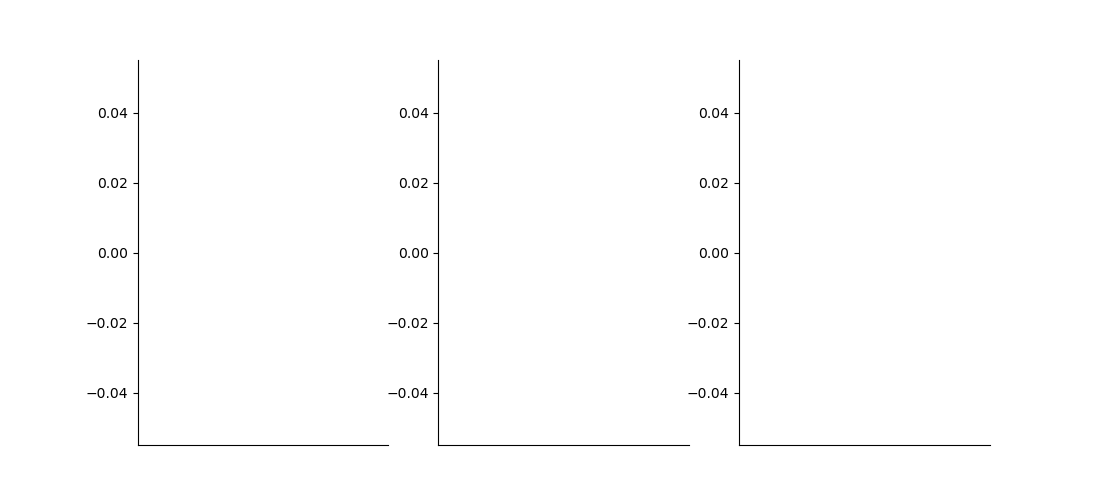

In [51]:
plt.close()
fig, axes = plt.subplots(1, 3, figsize=(11, 5), sharey=True)

# 24 categories for the 24 box-whisker plots
things_to_plot = [
    {
        'label': 'FDs_UNSEP_DNN_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].isna() & df_counts['Folder'].str.contains('DNN') & df_counts['Label'].str.contains('control')],
        'axes': 0,
    },
    {
        'label': 'FDs_UNSEP_DNN_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].isna() & df_counts['Folder'].str.contains('DNN') & df_counts['Label'].str.contains('pah')],
        'axes': 0,
    },
    {
        'label': 'FDs_ARTERY_DNN_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].str.contains('artery') & df_counts['Folder'].str.contains('DNN') & df_counts['Label'].str.contains('control')],
        'axes': 1,
    },
    {
        'label': 'FDs_ARTERY_DNN_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].str.contains('artery') & df_counts['Folder'].str.contains('DNN') & df_counts['Label'].str.contains('pah')],
        'axes': 1,
    },
    {
        'label': 'FDs_VEIN_DNN_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].str.contains('vein') & df_counts['Folder'].str.contains('DNN') & df_counts['Label'].str.contains('control')],
        'axes': 2,
    },
    {
        'label': 'FDs_VEIN_DNN_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].str.contains('vein') & df_counts['Folder'].str.contains('DNN') & df_counts['Label'].str.contains('pah')],
        'axes': 2,
    },
    {
        'label': 'FD_UNSEP_FACTOR_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].isna() & df_counts['Folder'].str.contains('FACTOR_0_5') & df_counts['Label'].str.contains('control')],
        'axes': 0,
    },
    {
        'label': 'FD_UNSEP_FACTOR_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].isna() & df_counts['Folder'].str.contains('FACTOR_0_5') & df_counts['Label'].str.contains('pah')],
        'axes': 0,
    },
    {
        'label': 'FD_ARTERY_FACTOR_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].str.contains('artery') & df_counts['Folder'].str.contains('FACTOR_0_5') & df_counts['Label'].str.contains('control')],
        'axes': 1,
    },
    {
        'label': 'FD_ARTERY_FACTOR_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].str.contains('artery') & df_counts['Folder'].str.contains('FACTOR_0_5') & df_counts['Label'].str.contains('pah')],
        'axes': 1,
    },
    {
        'label': 'FD_VEIN_FACTOR_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].str.contains('vein') & df_counts['Folder'].str.contains('FACTOR_0_5') & df_counts['Label'].str.contains('control')],
        'axes': 2,
    },
    {
        'label': 'FD_VEIN_FACTOR_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].str.contains('vein') & df_counts['Folder'].str.contains('FACTOR_0_5') & df_counts['Label'].str.contains('pah')],
        'axes': 2,
    },
    {
        'label': 'FD_UNSEP_FACTOR_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].isna() & df_counts['Folder'].str.contains('FACTOR_1_0') & df_counts['Label'].str.contains('control')],
        'axes': 0,
    },
    {
        'label': 'FD_UNSEP_FACTOR_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].isna() & df_counts['Folder'].str.contains('FACTOR_1_0') & df_counts['Label'].str.contains('pah')],
        'axes': 0,
    },
    {
        'label': 'FD_ARTERY_FACTOR_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].str.contains('artery') & df_counts['Folder'].str.contains('FACTOR_1_0') & df_counts['Label'].str.contains('control')],
        'axes': 1,
    },
    {
        'label': 'FD_ARTERY_FACTOR_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].str.contains('artery') & df_counts['Folder'].str.contains('FACTOR_1_0') & df_counts['Label'].str.contains('pah')],
        'axes': 1,
    },
    {
        'label': 'FD_VEIN_FACTOR_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].str.contains('vein') & df_counts['Folder'].str.contains('FACTOR_1_0') & df_counts['Label'].str.contains('control')],
        'axes': 2,
    },
    {
        'label': 'FD_VEIN_FACTOR_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].str.contains('vein') & df_counts['Folder'].str.contains('FACTOR_1_0') & df_counts['Label'].str.contains('pah')],
        'axes': 2,
    },
    {
        'label': 'FD_UNSEP_FACTOR_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].isna() & df_counts['Folder'].str.contains('FACTOR_1_5') & df_counts['Label'].str.contains('control')],
        'axes': 0,
    },
    {
        'label': 'FD_UNSEP_FACTOR_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].isna() & df_counts['Folder'].str.contains('FACTOR_1_5') & df_counts['Label'].str.contains('pah')],
        'axes': 0,
    },
    {
        'label': 'FD_ARTERY_FACTOR_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].str.contains('artery') & df_counts['Folder'].str.contains('FACTOR_1_5') & df_counts['Label'].str.contains('control')],
        'axes': 1,
    },
    {
        'label': 'FD_ARTERY_FACTOR_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].str.contains('artery') & df_counts['Folder'].str.contains('FACTOR_1_5') & df_counts['Label'].str.contains('pah')],
        'axes': 1,
    },
    {
        'label': 'FD_VEIN_FACTOR_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].str.contains('vein') & df_counts['Folder'].str.contains('FACTOR_1_5') & df_counts['Label'].str.contains('control')],
        'axes': 2,
    },
    {
        'label': 'FD_VEIN_FACTOR_SCALE',
        'df': df_counts[df_counts['Artery_Or_Vein'].str.contains('vein') & df_counts['Folder'].str.contains('FACTOR_1_5') & df_counts['Label'].str.contains('pah')],
        'axes': 2,
    },
]

# Create Widgets
options = [2, 4, 8, 16, 32, 64, 128, 256]
if ManySizeBy1_toggle:
    options = np.arange(2, 257)

slider = widgets.SelectionRangeSlider(
    options=options,
    index=(0, len(options)-1),
    description='Box Counts',
    disabled=False,
    continuous_update=False,
)

button = widgets.Button(
    description='Update',
    disabled=False,
    button_style='info',
    tooltip='Update graphs with new box counts',
)

w = widgets.HBox([
    slider,
    button,
])

# Generates stars for showing results of significance testing
# '**' --> Both tests significant
# '*'  --> Only one test significant
# ''   --> No tests significant
def star_for_significance(X1, X2):
    _, pvalue_twoSample = statistics.ttest_ind(X1, X2)
    _, pvalue_Wilcoxon = statistics.mannwhitneyu(X1, X2)
    
    if pvalue_twoSample < 0.05 and pvalue_Wilcoxon < 0.05:
        return '**'
    elif pvalue_twoSample < 0.05 or pvalue_Wilcoxon < 0.05:
        return '*'
    else:
        return ''

# Runs when button is clicked
# Grabs current slider values as limits for box sizes
# Generates FDs and plots as BW-plots with significance markers
def update(b):
    stats_list = [[], [], []]
    for thing_to_plot in things_to_plot:
        df_to_plot = thing_to_plot['df']
        
        lower_bound = slider.value[0]
        upper_bound = slider.value[1]

        if 'By1' in folder:
            m = 1
        else:
            m = 2

        if '20Size' in folder:
            mask = np.arange(20, 1, -m)
        elif 'ManySize' in folder:
            mask = np.arange(upper_bound, lower_bound-1, -m)
        else:
            lower_log = int(np.log(lower_bound) / np.log(2))
            upper_log = int(np.log(upper_bound) / np.log(2))
            mask = 2**np.arange(upper_log, lower_log-1, -1)

        FDs = []
        for _, row in df_to_plot.iterrows():
            mask_ind = len(row['Sizes']) - np.searchsorted(row['Sizes'][::-1], mask[::-1])[::-1] - 1

            sizes = row['Sizes'][mask_ind]
            counts = row['Counts'][mask_ind]
            
            # Handles cases where box sizes are lower than expected (<256)
            # Trims if actual box size is lower than upper_bound
            for i in range(0, len(sizes)-1):
                if sizes[i] < sizes[i+1]:
                    sizes = sizes[i+1:]
                    counts = counts[i+1:]
                    break
            
            sizes_log = np.log(sizes)
            counts_log = np.log(counts)

            poly = np.polynomial.polynomial.Polynomial.fit(x=sizes_log, y=counts_log, deg=1, domain=[])

            FDs.append(-poly.coef[1])

        stats_list[thing_to_plot['axes']].append(FDs)
    
    for i, stats in enumerate(stats_list):
        axes[i].cla()
        axes[i].boxplot(stats, whis=[0, 100], labels=['ctrl', 'pah', 'ctrl', 'pah', 'ctrl', 'pah', 'ctrl', 'pah'])
        
        axes[i].relim()
        axes[i].autoscale()
        
        axes[i].set_xlabel('DNN      0.5      1.0      1.5', fontsize=11, weight='bold')
        axes[i].set_title(titles[i])
    
    # Add Significance Markers
    sig_lists = [[], [], []]
    
    for i, stats in enumerate(stats_list):
        sig_lists[i].append(star_for_significance(stats[0], stats[1]))
        sig_lists[i].append(star_for_significance(stats[2], stats[3]))
        sig_lists[i].append(star_for_significance(stats[4], stats[5]))
        sig_lists[i].append(star_for_significance(stats[6], stats[7]))
    
    y = axes[0].get_ylim()[1]
    h = .02

    for i, sig_list in enumerate(sig_lists):
        for j, sig in enumerate(sig_list):
            if len(sig) > 0:
                x1, x2 = j*2+1, j*2+2
                axes[i].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c='black')
                axes[i].text((x1+x2)*.5, y+h, sig, ha='center', va='bottom', color='black')
    
    axes[0].set_ylabel('Fractal Dimension', fontsize=11)
    fig.suptitle(f'FD for Box Sizes [{lower_bound}, {upper_bound}]')

stats_list = [[], [], []]
titles = ['Unseparated', 'Arterial', 'Venous']
for i, stats in enumerate(stats_list):
    axes[i].boxplot(stats, whis=[0, 100])
    axes[i].relim()
    axes[i].autoscale()
    
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

    axes[i].tick_params(axis='y', reset=True, right=False)

plt.show()

fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

update(button)
button.on_click(update)

w